## Imports

In [1]:
import numpy as np
import pandas as pd
import math

In [2]:
#data cleaning
import clean
import preproc

#RNN cleaning
from RNN_preproc_uni import get_train_test


In [3]:
#model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import datetime
from datetime import date, timedelta
from clean import clean_all, get_data, get_bairros_data
from preproc import get_format, get_popfile, clean_pop_data, extract_ts
idx = pd.IndexSlice

## Data

In [4]:
data1, data2, data3, data4 = clean.get_data()
data = clean.clean_all(data1, data2, data3, data4, clean.get_bairros_data())

In [5]:
preproc_data_n, preproc_data_rate = preproc.get_format(data)

In [6]:
X_train, y_train, X_test, y_test = get_train_test(preproc_data_rate, 1000, 100, "all_AR")


/Users/kavithaapp/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((30000, 69, 1), (30000, 31), (7500, 69, 1), (7500, 31))

## Model

In [8]:
def init_model():
    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.001)
    
    model = models.Sequential()
    model.add(layers.LSTM(30, return_sequences=True, activation='tanh',input_shape = (69,1)))
    model.add(layers.LSTM(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(31, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

In [9]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20, restore_best_weights=True)

In [10]:
# Fitting the model
def fit(model,x,y):
    hist = model.fit(x, y,
            validation_split=0.3,
            epochs=100, 
            batch_size=16,
            callbacks=[es], verbose=1)
    return hist

In [11]:
model = init_model()
history = fit(model, X_train,y_train)

2022-03-06 14:17:28.514320: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-06 14:17:28.744900: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
1313/1313 [==============================] - 27s 20ms/step - loss: 0.0631 - mean_absolute_percentage_error: 4555505.5000 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 4390650.5000
Epoch 2/100
1313/1313 [==============================] - 26s 20ms/step - loss: 0.0516 - mean_absolute_percentage_error: 3075970.0000 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 5065161.5000
Epoch 3/100
1313/1313 [==============================] - 26s 20ms/step - loss: 0.0512 - mean_absolute_percentage_error: 3153289.5000 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 4550763.5000
Epoch 4/100
1313/1313 [==============================] - 26s 19ms/step - loss: 0.0509 - mean_absolute_percentage_error: 3126881.0000 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 4607367.0000
Epoch 5/100
1313/1313 [==============================] - 26s 20ms/step - loss: 0.0508 - mean_absolute_percentage_error: 3075692.5000 - val_loss: 0.0209 - val_mean_absolute_percentage_error

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 69, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1640      
_________________________________________________________________
dense (Dense)                (None, 5)                 55        
_________________________________________________________________
dense_1 (Dense)              (None, 31)                186       
Total params: 5,721
Trainable params: 5,721
Non-trainable params: 0
_________________________________________________________________


In [27]:
y_pred = history.model.predict(X_test)

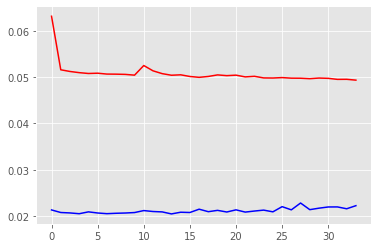

In [28]:
plt.plot(history.history["loss"],c="red")
plt.plot(history.history["val_loss"], c="blue")

In [29]:
y_pred[0]

array([0.0513028 , 0.04953071, 0.04320487, 0.05099588, 0.05309632,
       0.05321736, 0.06000119, 0.05287004, 0.05917627, 0.0580887 ,
       0.05222526, 0.0564879 , 0.0522838 , 0.05073046, 0.05271966,
       0.05294979, 0.0468304 , 0.05041108, 0.05539678, 0.04785477,
       0.04949731, 0.04358396, 0.04930948, 0.04900224, 0.04955131,
       0.05169599, 0.05076971, 0.05052479, 0.04960932, 0.05057566,
       0.05843619], dtype=float32)

In [30]:
y_test.shape, y_pred.shape

((7500, 31), (7500, 31))

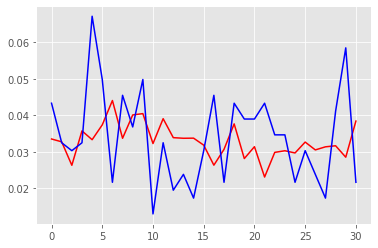

In [31]:
plt.plot(range(31),y_pred[600],color="r")
plt.plot(range(31),y_test[600],color="b")

In [101]:
data=preproc_data_rate.droplevel(level=0,axis=1)

In [102]:
#split test/train... use test only
len_ = int(0.8*df.shape[0])
df_test = df[len_:]

sample_len = 100 #sample length
pred_len = 31 #prediction length
train_len = sample_len - pred_len #length of X-variable
df = data
y_pred_order_int = []
size = int((df_test.shape[0]-(sample_len-pred_len))/pred_len)+1
no_regions = 30

for i in range(size):
    data_select = np.array(df_test[i*pred_len:i*pred_len+(sample_len-pred_len)]).T
    X_test_order = data_select.reshape(data_select.shape[0],data_select.shape[1],1)
    y_pred_order = history.model.predict(X_test_order).tolist()
    y_pred_order_int.append(y_pred_order)

y_pred_order_int=np.array(y_pred_order_int)

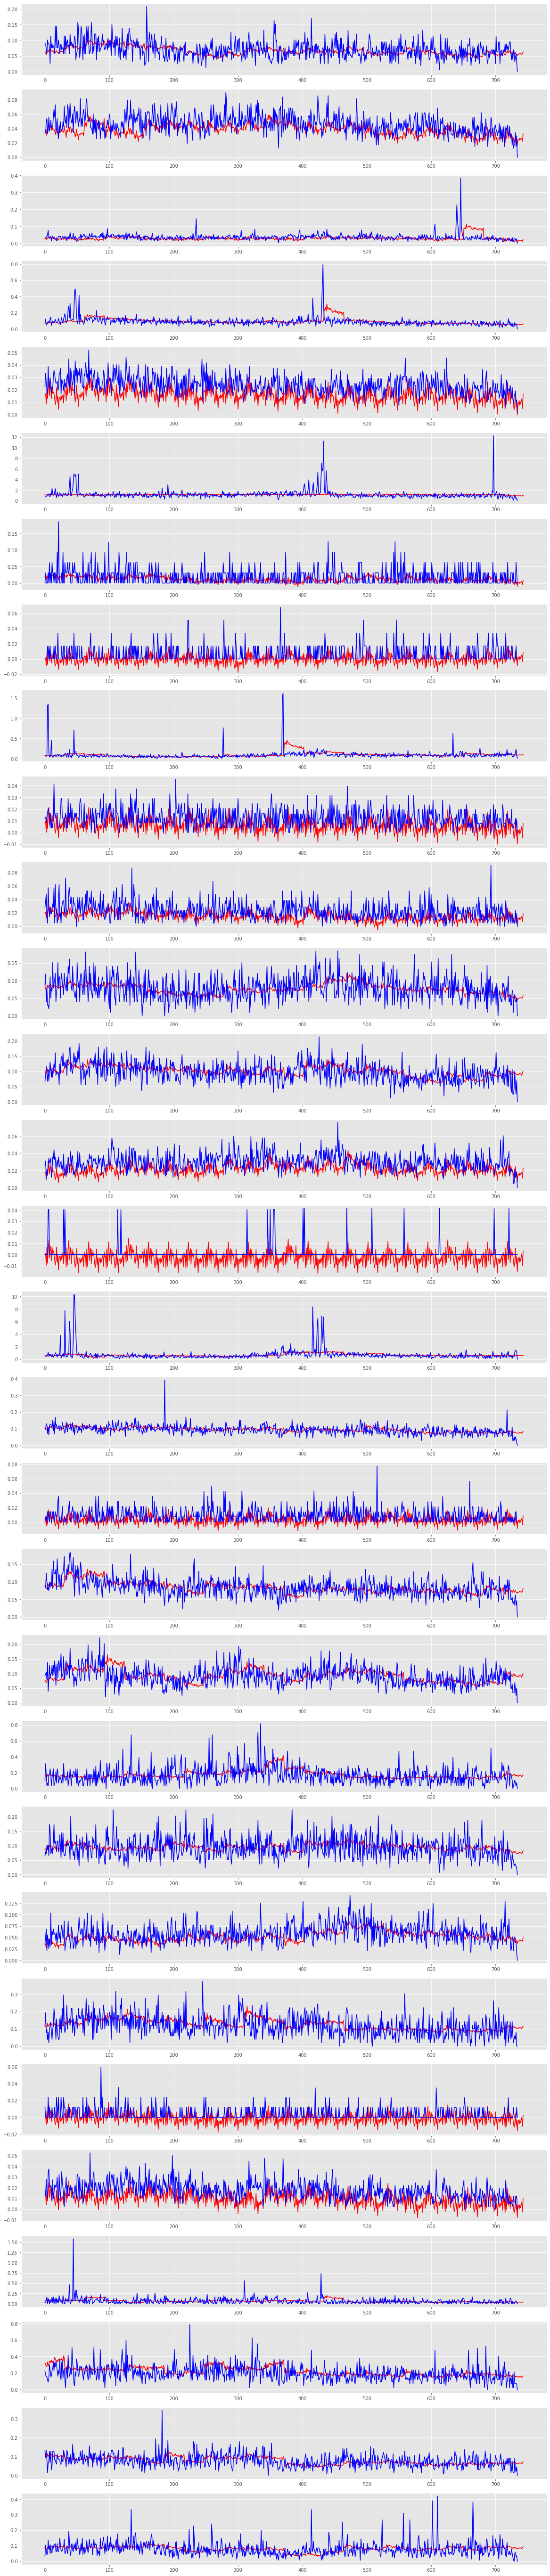

In [103]:
fig, axs = plt.subplots(no_regions,1,figsize=(20,100))
for r in range(no_regions):
    y_pred_order = np.concatenate(y_pred_order_int[:,r,:])
    actual = np.array(data_test[(length-pred_len):])[:,r]
    axs[r].plot(y_pred_order,color="r")
    axs[r].plot(actual,color="b")

plt.show()
